In [22]:
import pandas as pd
import numpy as np
import os
import glob
import librosa as librosa
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib inline
import librosa.display
from IPython.display import Audio
import time
import gc
from scipy.io.wavfile import write

In [3]:
directory_path = 'data/Respiratory_Sound_Database/audio_and_txt_files'
text_files = glob.iglob(directory_path + '/*.txt', recursive=True)
text_files_list = list(text_files)

dfs = []
for file in text_files_list:
    content = pd.read_csv(file, names = ["start_time", "end_time", "crackles", "wheezes"], delimiter = "\t")
    patient_number = file.split("_")[5][6:]
    content['patient'] = int(patient_number)
    dfs.append(content)
samples = pd.concat(dfs)

print("There are", len(samples), "cycles")
print("There are", len(text_files_list), "samples")

There are 6898 cycles
There are 920 samples


In [4]:
# new directories to be created
spectrograms_path = "data/spectrograms"
clips_by_cycle_path = "data/Respiratory_Sound_Database/clips_by_cycle"

# create the directories
os.makedirs(spectrograms_path, exist_ok=True)
os.makedirs(clips_by_cycle_path, exist_ok=True)

In [5]:
# clear output of folders created above
output_folders = ['data/spectrograms','data/Respiratory_Sound_Database/clips_by_cycle']
for folder in output_folders:
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        # Remove the file
        if os.path.isfile(file_path):
            os.remove(file_path)

    print(f"Contents of {folder} cleared.")



Contents of data/spectrograms cleared.
Contents of data/Respiratory_Sound_Database/clips_by_cycle cleared.


In [25]:
output_folder = 'data/spectrograms'
# converts file, where file is a string (name of the file), into a string with the given format, where format is a string
# assumes the format already in the file is 3 characters long
# if cycle > 0, it adds "cycle _" to the end of the file name before the ending
# if cycle = 0, it leaves the rest of the file as is
def convert_type(file, format, cycle):
    if cycle > 0:
        file = file[0:len(file)-4] + "_cycle" + str(cycle) + "." + format
    else:
        file = file[0:len(file)-3] + format
    return file


# divide audio_file into its respiratory cycles
# takes the name of the audio file (.wav) as a string as the argument
def divide_into_cycles(audio_file_name):
    # take just the timestamps for the respiratory cycles- ignore crackles and wheezes
    audio_file_name_as_txt = directory_path + "/" + convert_type(audio_file_name, "txt", 0)
    timestamps = np.loadtxt(audio_file_name_as_txt, delimiter='\t')
    timestamps = timestamps[:, :2]
    
    return timestamps


def generate_spectrogram(audio_file):
    # load the audio file
    y, sr = librosa.load(audio_file)
    
    audio_file_name = os.path.basename(audio_file)
    # find where the timestamps of audio_file are
    timestamps = divide_into_cycles(audio_file_name) # list
    
    # find the length of the shortest spectrogram
    min = -1
    for cycle in timestamps:
        start_time = cycle[0]
        end_time = cycle[1]
        length = end_time - start_time
        if min == -1 or length < min:
            min = length
    
    # make a mel db spectrogram for each respiratory cycle using the timestamps
    cycle_number = 1
    for cycle in timestamps:
        # take the portion of the audio that contains this respiratory cycle

        # start and end time in seconds
        start_time = cycle[0]
        end_time = cycle[1]
        
        # determine how much of the audio segment we need to crop
        diff = (end_time - start_time) - min
        crop_amt = int(diff / 2)
        
        # convert the start and end times to sample indices
        start_sample = int(start_time * sr) + crop_amt
        end_sample = int(end_time * sr) - crop_amt
        
        # extract the audio segment
        audio_segment = y[start_sample:end_sample]
        
        spectrogram_name = convert_type(audio_file_name, "jpg", cycle_number)
        
        # make the mel db spectrogram based on that audio segment
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_segment, n_fft=2048, hop_length=512)), ref=np.max)
        # display the spectrogram
        plt.figure(figsize=(5, 2))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
        plt.axis('off')
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0) # removes the white space around the spectrogram
        # plt.colorbar(format='%+2.0f dB')
        # plt.title(spectrogram_name)

        # save the spectrogram to the output folder
        output_path = os.path.join(output_folder, spectrogram_name)
        plt.savefig(output_path)
        plt.close()
        
        cycle_number += 1


In [7]:
#gets all audio files
audio_files = glob.iglob(directory_path + '/*.wav', recursive=True)

In [8]:
#creates spectrograms from audio files using generate_spectrogram
begin_time = time.time()
file_number = 0

for audio_file in audio_files:
    generate_spectrogram(audio_file)
    file_number += 1

    # Print progress
    if file_number % 10 == 0:
        print(f"Processed {file_number} files so far in {time.time() - begin_time} seconds")
        gc.collect()

print(f"Processed a batch of {file_number} files in {time.time() - begin_time} seconds")

Processed 10 files so far in 9.009783744812012 seconds
Processed 20 files so far in 16.32257580757141 seconds
Processed 30 files so far in 23.228391885757446 seconds
Processed 40 files so far in 28.9737868309021 seconds
Processed 50 files so far in 35.0533230304718 seconds
Processed 60 files so far in 40.87582087516785 seconds
Processed 70 files so far in 47.0378897190094 seconds
Processed 80 files so far in 53.05445671081543 seconds
Processed 90 files so far in 59.05989480018616 seconds
Processed 100 files so far in 66.83779883384705 seconds
Processed 110 files so far in 73.71211767196655 seconds
Processed 120 files so far in 79.78153777122498 seconds
Processed 130 files so far in 85.69358682632446 seconds
Processed 140 files so far in 91.55472779273987 seconds
Processed 150 files so far in 97.78425979614258 seconds
Processed 160 files so far in 105.97735095024109 seconds
Processed 170 files so far in 112.37658882141113 seconds
Processed 180 files so far in 118.46802377700806 seconds


In [9]:
#method to generate audio clips by cycle
def generate_audio_clips(audio_file, output_folder):
    # load the audio file
    y, sr = librosa.load(audio_file)
    
    audio_file_name = os.path.basename(audio_file)
    # find where the timestamps of audio_file are
    timestamps = divide_into_cycles(audio_file_name) # list
    
    # make an audio clip for each respiratory cycle using the timestamps
    cycle_number = 1
    for cycle in timestamps:
        # take the portion of the audio that contains this respiratory cycle

        # start and end time in seconds
        start_time = cycle[0]
        end_time = cycle[1]
        
        # convert the start and end times to sample indices
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)
        
        # extract the audio segment
        audio_segment = y[start_sample:end_sample]
        
        audio_clip_name = convert_type(audio_file_name, "wav", cycle_number)
        
        # save the audio clip to the output folder
        output_path = os.path.join(output_folder, audio_clip_name)
        write(output_path, sr, audio_segment)
        
        cycle_number += 1

In [10]:
directory_path = 'data/Respiratory_Sound_Database/audio_and_txt_files'
output_folder = 'data/Respiratory_Sound_Database/clips_by_cycle'

audio_files = glob.iglob(directory_path + '/*.wav', recursive=True)

#generates cut audio clips by cycle and puts them in clips_by_cycle folder
for audio_file in audio_files:
    generate_audio_clips(audio_file, output_folder)

In [14]:
# get the list of sound files
sound_files = glob.glob('data/Respiratory_Sound_Database/clips_by_cycle/*.wav')

# get the list of spectrogram files
spectrogram_files = glob.glob('data/spectrograms/*.jpg')

# create a DataFrame for sound files
df_sound = pd.DataFrame({
    'filename': [os.path.splitext(os.path.basename(x))[0] for x in sound_files],
    'sound_file': sound_files
})

# create a DataFrame for spectrogram files
df_spectrogram = pd.DataFrame({
    'filename': [os.path.splitext(os.path.basename(x))[0] for x in spectrogram_files],
    'spectrogram_file': spectrogram_files
})

# merge the DataFrames on the 'filename' column
df = pd.merge(df_sound, df_spectrogram, on='filename')

# print the DataFrame
print(df)

#df now contains filename, sound_file, and spectrogram_file

                            filename  \
0      215_1b3_Tc_sc_Meditron_cycle6   
1      178_1b2_Al_mc_AKGC417L_cycle7   
2     120_1b1_Pl_sc_Meditron_cycle16   
3      166_1p1_Pl_sc_Meditron_cycle4   
4      200_3p4_Pr_mc_AKGC417L_cycle2   
...                              ...   
6893   138_1p3_Tc_mc_AKGC417L_cycle4   
6894   131_1b1_Al_sc_Meditron_cycle8   
6895   216_1b1_Pl_sc_Meditron_cycle1   
6896  222_1b1_Lr_sc_Meditron_cycle11   
6897   186_2b3_Tc_mc_AKGC417L_cycle4   

                                             sound_file  \
0     data/Respiratory_Sound_Database/clips_by_cycle...   
1     data/Respiratory_Sound_Database/clips_by_cycle...   
2     data/Respiratory_Sound_Database/clips_by_cycle...   
3     data/Respiratory_Sound_Database/clips_by_cycle...   
4     data/Respiratory_Sound_Database/clips_by_cycle...   
...                                                 ...   
6893  data/Respiratory_Sound_Database/clips_by_cycle...   
6894  data/Respiratory_Sound_Database/clips_by_

In [15]:
patient_data=pd.read_csv('data/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
path='data/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]

In [16]:
def getFilenameInfo(file):
    return file.split('_')

In [17]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','wheezes'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)

In [18]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')
data=pd.merge(files_df,patient_data,on='pid')
print(df.head())
print(data.head())

                         filename  \
0   215_1b3_Tc_sc_Meditron_cycle6   
1   178_1b2_Al_mc_AKGC417L_cycle7   
2  120_1b1_Pl_sc_Meditron_cycle16   
3   166_1p1_Pl_sc_Meditron_cycle4   
4   200_3p4_Pr_mc_AKGC417L_cycle2   

                                          sound_file  \
0  data/Respiratory_Sound_Database/clips_by_cycle...   
1  data/Respiratory_Sound_Database/clips_by_cycle...   
2  data/Respiratory_Sound_Database/clips_by_cycle...   
3  data/Respiratory_Sound_Database/clips_by_cycle...   
4  data/Respiratory_Sound_Database/clips_by_cycle...   

                                    spectrogram_file  
0  data/spectrograms/215_1b3_Tc_sc_Meditron_cycle...  
1  data/spectrograms/178_1b2_Al_mc_AKGC417L_cycle...  
2  data/spectrograms/120_1b1_Pl_sc_Meditron_cycle...  
3  data/spectrograms/166_1p1_Pl_sc_Meditron_cycle...  
4  data/spectrograms/200_3p4_Pr_mc_AKGC417L_cycle...  
   start    end  crackles  wheezes  pid mode                filename disease
0  0.022  0.364         0        

In [19]:
# create a new column 'filename_cycle'
data['filename_cycle'] = data.groupby('filename').cumcount() + 1

# concatenate 'filename' and 'filename_cycle' to create a new column
data['filename_cycle'] = data['filename'] + '_cycle' + data['filename_cycle'].astype(str)

data['cycle_number'] = data['filename_cycle'].apply(lambda x: int(x.split('_cycle')[-1]))

data = data.drop('filename', axis=1)

# rename the 'filename_cycle' column to 'filename'
data = data.rename(columns={'filename_cycle': 'filename'})

# print the DataFrame
print(data)

       start     end  crackles  wheezes  pid mode         disease  \
0      0.022   0.364         0        0  148   sc            URTI   
1      0.364   2.436         0        0  148   sc            URTI   
2      2.436   4.636         0        0  148   sc            URTI   
3      4.636   6.793         0        0  148   sc            URTI   
4      6.793   8.750         0        0  148   sc            URTI   
...      ...     ...       ...      ...  ...  ...             ...   
6893  16.946  19.156         1        0  130   mc            COPD   
6894   0.022   3.450         0        0  116   sc  Bronchiectasis   
6895   3.450  10.507         0        1  116   sc  Bronchiectasis   
6896  10.507  17.336         0        1  116   sc  Bronchiectasis   
6897  17.336  19.950         0        0  116   sc  Bronchiectasis   

                           filename  cycle_number  
0     148_1b1_Al_sc_Meditron_cycle1             1  
1     148_1b1_Al_sc_Meditron_cycle2             2  
2     148_1b1_A

In [20]:
# merge the DataFrames on the 'filename' column
merged_df = pd.merge(df, data, on='filename')

#rearrange columns 
new_columns_order = ['filename', 'pid', 'cycle_number', 'start', 'end', 'crackles', 'wheezes', 'mode', 'disease', 'sound_file', 'spectrogram_file']
merged_df = merged_df[new_columns_order]

#sort rows based on patient id then cycle number
merged_df = merged_df.sort_values(['pid', 'cycle_number'])

# save the DataFrame to a CSV file
merged_df.to_csv('data/data_by_cycle.csv', index=False)


In [21]:
demographic_df = pd.read_csv('demographic_info.txt', sep=' ', header=None)
demographic_df.columns = ['pid', 'age', 'sex', 'adult_BMI', 'child_weight', 'child_height']

# Create a mask to filter rows where weight and height are not NA
mask = (demographic_df['child_weight'].notna()) & (demographic_df['child_height'].notna())

# Calculate child BMI using weight and height
demographic_df.loc[mask, 'child_BMI'] = demographic_df.loc[mask, 'child_weight'] / (demographic_df.loc[mask, 'child_height'] / 100) ** 2
demographic_df['child_BMI'] = demographic_df['child_BMI'].round(2)
# BEGIN: New Cell

# Create a new column 'bmi' based on 'adult_BMI' and 'child_BMI'
demographic_df['bmi'] = demographic_df['adult_BMI'].fillna(demographic_df['child_BMI'])
# END: New Cell

second_merge=pd.merge(merged_df,demographic_df,on='pid')
second_merge.to_csv('data/data_by_cycle_and_demographics.csv', index=False)

In [22]:
import re
filenames = second_merge.filename
filename_df = pd.DataFrame()

filename_df['pid2'] = [re.findall(r'^(\d+)_', filename)[0] for filename in filenames]

#adds the recording index to the data frame
recording_index_list = []
for filename in filenames:
    match = re.findall(r'\d+_(\d+[a-z]\d+)_', filename)
    if match:
        recording_index_list.append(match[0])
    else:
        recording_index_list.append(None)
filename_df['recording_index'] = recording_index_list


chest_location_list = []
for filename in filenames:
    match = re.findall(r'_([A-Z][a-z])_', filename)
    if match:
        chest_location_list.append(match[0])
    else:
        chest_location_list.append(None)

filename_df['chest_location'] = chest_location_list



acquisition_position_list = []
for filename in filenames:
    match = re.findall(r'_([a-z][a-z])_', filename)
    if match:
        acquisition_position_list.append(match[0])
    else:
        acquisition_position_list.append(None)

filename_df['acquisition_position'] = acquisition_position_list

possible_recording_equipment = ["AKGC417L", "LittC2SE", "Litt3200", "Meditron"]

# Create an empty list to store the recording equipment
recording_equipment_list = []

# Loop through each filename
for filename in filenames:
    # Extract the recording equipment from the filename
    recording_equipment = None
    for equipment in possible_recording_equipment:
        if equipment in filename:
            recording_equipment = equipment
            break
    
    # Append the recording equipment to the list
    recording_equipment_list.append(recording_equipment)

# Create a DataFrame with the recording equipment list
filename_df['recording_equipment'] = recording_equipment_list

filename_df['cycle_number2'] = [re.findall(r'cycle(\d+)', filename)[0] for filename in filenames]
filename_df['filename'] = filenames
print(filename_df)

     pid2 recording_index chest_location acquisition_position  \
0     101             1b1             Pr                   sc   
1     101             1b1             Al                   sc   
2     101             1b1             Pr                   sc   
3     101             1b1             Al                   sc   
4     101             1b1             Pr                   sc   
...   ...             ...            ...                  ...   
6893  226             1b1             Al                   sc   
6894  226             1b1             Al                   sc   
6895  226             1b1             Ll                   sc   
6896  226             1b1             Pl                   sc   
6897  226             1b1             Pl                   sc   

     recording_equipment cycle_number2                        filename  
0               Meditron             1   101_1b1_Pr_sc_Meditron_cycle1  
1               Meditron             1   101_1b1_Al_sc_Meditron_cycle1  


In [23]:
final_merge_df = pd.merge(second_merge, filename_df, on='filename')
final_merge_df = final_merge_df.drop(columns=['filename', 'cycle_number2', 'pid2'])
final_merge_df.to_csv('data/data_complete.csv', index=False)


In [23]:
import soundfile as sf
from scipy.signal import butter, lfilter

# new directories to be created
downsampled_clips = "data/downsampled_clips"

# create the directories
os.makedirs(downsampled_clips, exist_ok=True)

# define a function to apply a Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if low > 1: low = 1
    if high > 1: high = 1
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# specify the directory containing the original audio files
directory = 'data/Respiratory_Sound_Database/audio_and_txt_files'
output_folder = 'data/downsampled_clips'

for filename in os.listdir(directory):
    # check if the file is an audio file
    if filename.endswith('.wav'):
        # load the audio file with a sample rate of 4000 Hz
        y, sr = librosa.load(os.path.join(directory, filename), sr=4000)
        
        # apply the Butterworth band-pass filter
        y = butter_bandpass_filter(y, lowcut=10, highcut=1800, fs=sr)
        
        # apply standard normalization
        y = (y - np.mean(y)) / np.std(y)
        
        # save the processed audio file to the new directory
        sf.write(os.path.join(output_folder, filename), y, sr)

In [26]:
# new directories to be created
normalized_spectrograms = "data/normalized_spectrograms"

# create the directories
os.makedirs(normalized_spectrograms, exist_ok=True)

output_folder = normalized_spectrograms
directory = "data/downsampled_clips"
directory_path = 'data/Respiratory_Sound_Database/audio_and_txt_files'

for filename in os.listdir(directory):
    # check if the file is an audio file
    if filename.endswith('.wav'):
        # generate the spectrogram for the audio file
        generate_spectrogram(os.path.join(directory, filename))

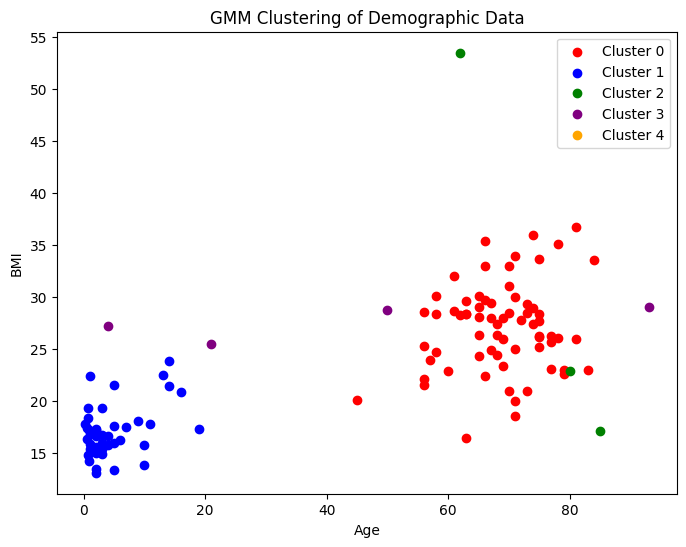

In [42]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Load the data
data = pd.read_csv('data/data_complete.csv')

# create a dataframe with sample data

data = data[['pid', 'age', 'bmi']].dropna()
data = data.groupby('pid').first().reset_index()
features = data[['age', 'bmi']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

gmm = GaussianMixture(n_components=4, random_state=42, init_params='k-means++')
gmm.fit(scaled_features)

cluster_labels = gmm.predict(scaled_features)
data['cluster'] = cluster_labels

plt.figure(figsize=(8, 6))

# Color mapping for clusters
color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange'}

# Plot data points with color-coded clusters
for cluster_label, color in color_map.items():
    cluster_data = data[data['cluster'] == cluster_label]
    plt.scatter(cluster_data['age'], cluster_data['bmi'], c=color, label=f'Cluster {cluster_label}')

plt.title('GMM Clustering of Demographic Data')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend()
plt.show()




In [2]:
import glob
from PIL import Image
import numpy as np

# Define the folder path
folder_path = 'data/spectrograms/'

# Get the file paths of all the image files in the folder
image_files = glob.glob(folder_path + '*.jpg')

# Create an empty list to store the image arrays
image_array = []

# Iterate over the image files
for file_path in image_files:
    # Open the image file
    image = Image.open(file_path)
    
    # Convert the image to an array
    image_array.append(np.array(image))

# Convert the list of image arrays to a single numpy array
image_array = np.array(image_array)
print(image_array.shape)

test_sample = image_array[0:5]
print(test_sample.shape)
import matplotlib.pyplot as plt




(9671, 200, 500, 3)
(5, 200, 500, 3)


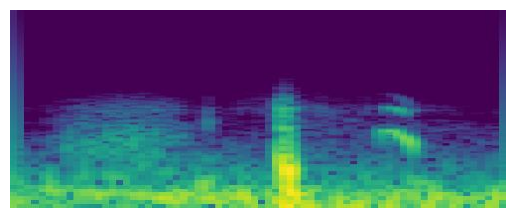

In [12]:
# Show the image
plt.imshow(test_sample[3])
plt.axis('off')
plt.show()

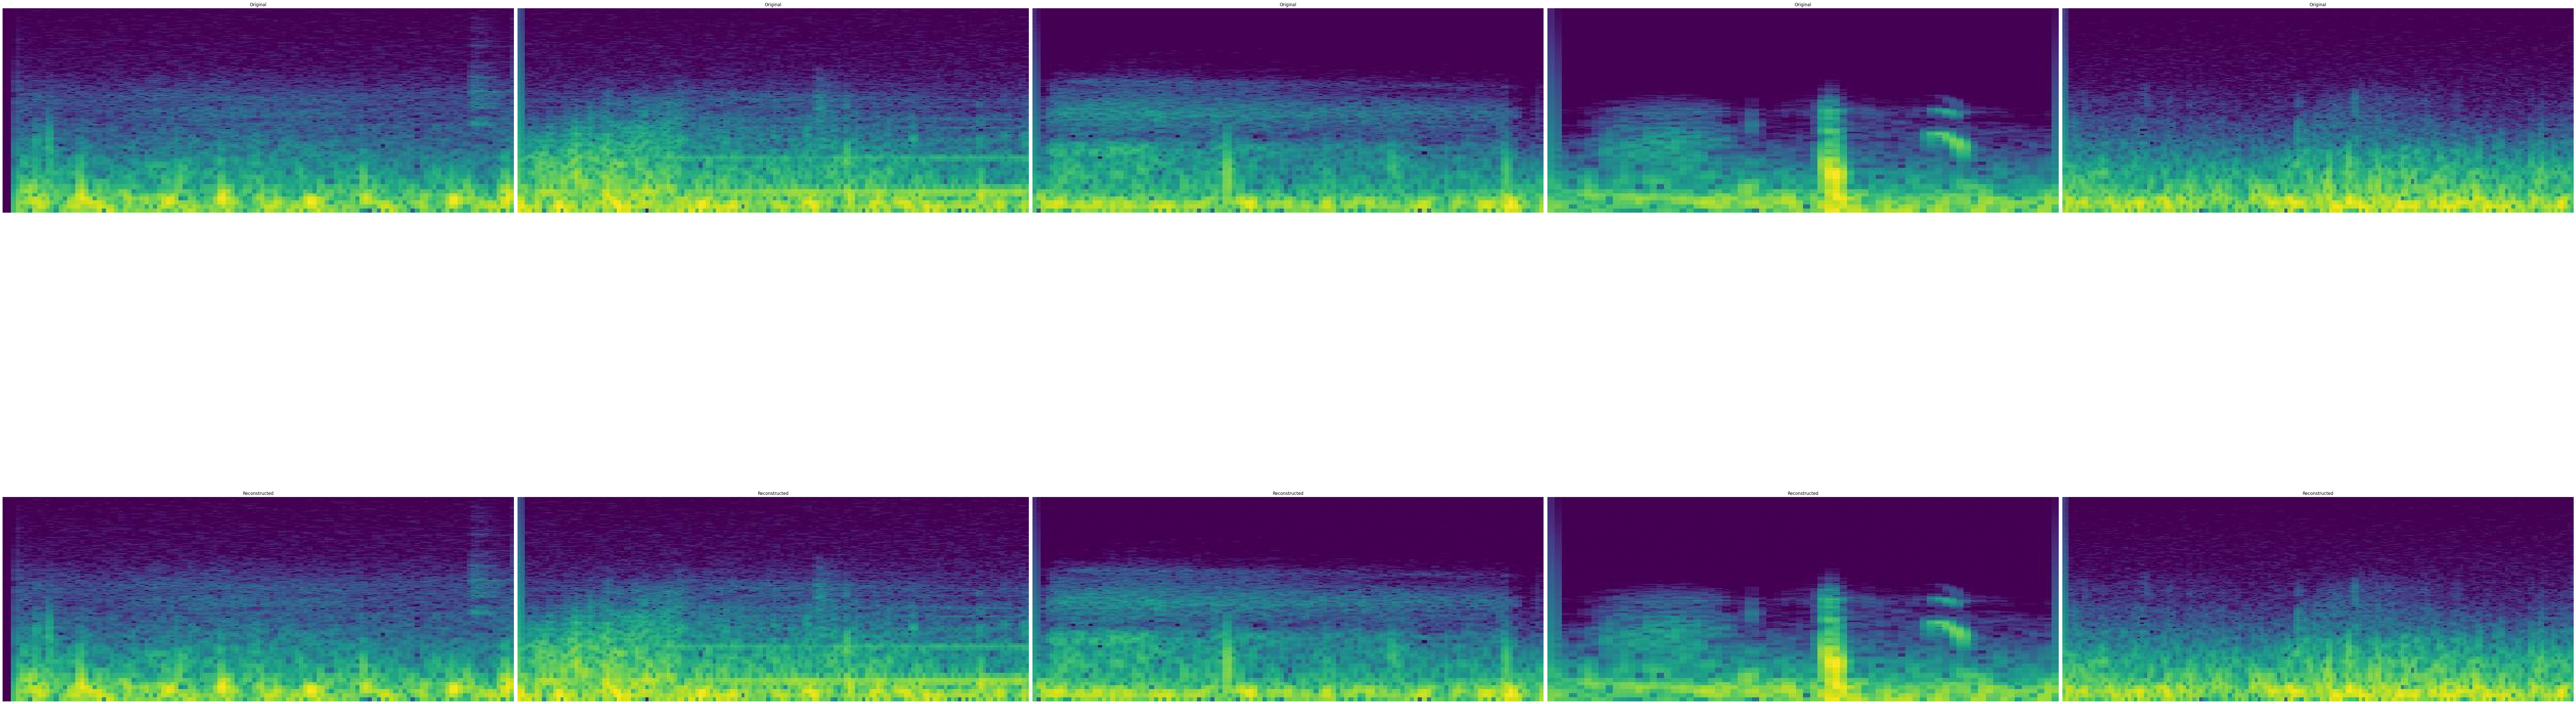

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA
pca = PCA(n_components=5)
n_samples, height, width, channels = test_sample.shape
test_sample_reshaped = test_sample.reshape(n_samples, height * width * channels)

pca.fit(test_sample_reshaped)

transformed_data = pca.transform(test_sample_reshaped)

# Inverse transform to reconstruct images
reconstructed_data = pca.inverse_transform(transformed_data)
reconstructed_images = reconstructed_data.reshape(n_samples, height, width, channels)

# Visualize original and reconstructed images
plt.figure(figsize=(100, 50))
for i in range(n_samples):
    # Original image
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(test_sample[i])
    plt.title('Original')
    plt.axis('off')
    
    # Reconstructed image
    plt.subplot(2, n_samples, n_samples + i + 1)
    plt.imshow(reconstructed_images[i].astype(np.uint8))
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()